## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab 

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [196]:
# !mkdir -p /root/.kaggle
# !mv kaggle.json /root/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions list

## Download Dataset from Kaggle

In [197]:
# !kaggle competitions download -c bci-homework-3-kaggle-judge
# !unzip -qq bci-homework-3-kaggle-judge.zip -d ./
# !ls -l BCI_hw3_dataset

## Install Package (Optional)

In [198]:
# !pip install torchinfo
# !pip install mne

## Import Package and Library to Python Session

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "/kaggle/input/bci-homework-3-kaggle-judge/BCI_hw3_dataset/train"
DATASET_DIR_TEST = "/kaggle/input/bci-homework-3-kaggle-judge/BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "/kaggle/input/bci-homework-3-kaggle-judge/BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## EEG Model

### EEGNet

In [200]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### ShallowConvNet

In [201]:
class ShallowConvNet(nn.Module):
    """Shallow ConvNet model from Schirrmeister et al 2017.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    NT: int
        Number of temporal filters.
    NS: int
        Number of spatial filters.
    tkerLen: int
        Length of the temporal filter.
    pool_tLen: int
        Length of temporal pooling filter.
    pool_tStep: int
        Length of stride of temporal pooling filters.
    batch_norm: bool
        Whether to use batch normalization.
    dropRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1703.05051
    """
    def __init__(self, C, N, nb_classes, NT=40, NS=40, tkerLen=12, pool_tLen=35, pool_tStep=7, batch_norm=True, dropRate=0.25):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, NT, (1, tkerLen), bias=False)
        self.conv2 = nn.Conv2d(NT, NS, (C, 1), bias=False)
        self.Bn1 = nn.BatchNorm2d(NS)
        self.AvgPool1 = nn.AvgPool2d((1, pool_tLen), stride=(1, pool_tStep))
        self.Drop1 = nn.Dropout(dropRate)
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x
    
    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.AvgPool1(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet

In [202]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """Advanced SCCNet model without permutation layer.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu
        # self.layer = ...

    def forward(self, x):
        return x


In [203]:
# TODO: finish the SCCNet
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    # You can only add extra argument to this function, do NOT remove the existed arguments
    # The model structure should be dynamic changed by the provided arguments,
    # There will be a score penalty if SCCNet structure is static
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5): 
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu
        ### TODO: construct the model layers, refer to paper ###
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, Nu, (C, Nt), padding='valid', bias=False),
            nn.BatchNorm2d(Nu)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, Nc, (Nu, 12), padding='valid', bias=False),
            nn.BatchNorm2d(Nc),
            nn.Dropout(dropoutRate)
        )
        self.avg = nn.AvgPool2d((1, 62), stride=(1, 12))
        self.flat = nn.Flatten()
        s = self.get_size(C, N)[1]
        self.classifier = nn.Sequential(
            nn.Linear(s, nb_classes),
            nn.Softmax(dim=1)
        )
        
        # conv1 (kernel size (C, Nt))
        # dim premutation (2, 1, 3)
        # conv2 (kernel size (Nc, 12))
        # for both conv, zero padding and batch norm, 
        # l2 regularize coeff 0.0001, dropout 0.5 
        # avgpool (size (1, 62), stride (1, 12))
        # softmax (4)
        

    def forward(self, x):
        ### TODO: forwarding rule ###
        # ex. x = self.layer(x)
        # note. remember the square activation and log activation
        x = self.conv1(x)
        x = torch.permute(x, (0, 2, 1, 3))
        x = self.conv2(x)
        x = x ** 2
        x = torch.permute(x, (0, 2, 1, 3))
        x = self.avg(x)
        x = torch.log(x)
        x = self.flat(x)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        # Optional TODO: auto calculate fully-connected layer helper function
        x = torch.ones((1, 1, C, N))
        x = self.conv1(x)
        x = torch.permute(x, (0, 2, 1, 3))
        x = self.conv2(x)
        x = torch.permute(x, (0, 2, 1, 3))
        x = self.avg(x)
        x = self.flat(x)
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

In [204]:
scc = SCCNet(20, 1000, 4)
print(scc)

SCCNet(
  (conv1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(20, 1), stride=(1, 1), padding=valid, bias=False)
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(20, 12), stride=(1, 1), padding=valid, bias=False)
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (avg): AvgPool2d(kernel_size=(1, 62), stride=(1, 12), padding=0)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=1560, out_features=4, bias=True)
    (1): Softmax(dim=1)
  )
)


## Train

In [205]:
# config training scheme, mode, hyperparam
eegmodel = ShallowConvNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
scheme = "sift"  # "ind", "si", "sd", "sift"
epochs = 200
batch_size = 16
lr = 1e-3
savepath = "checkpoints"
os.makedirs(savepath, exist_ok=True)

subject_id = "01"

### load data

In [206]:
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

if scheme == "si" or scheme == "sift":
    ### TODO: subject-independent training scheme, subject-independent + fine-tuning shared same training data representaion ###
    
    valid_id = '01' # chosen valid set
    
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{valid_id}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

    for i in range(1, 10):
        subject_id = '0' + str(i)
        if subject_id == valid_id:
            continue
        mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
        x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

        for c in range(4):
            x_, y_ = x_data[y_data == c], y_data[y_data == c]
            x_train = np.append(x_train, x_, axis=0)
            y_train = np.append(y_train, y_, axis=0)
        
elif scheme == "sd": # subject-dependent, target `subject` participate in training stage, `testing data should still be LEAVE-OUT`
    ### TODO: subject-dependent training scheme ###
    
    valid_id = '01' # chosen valid set
    
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{valid_id}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

    for i in range(1, 10):
        subject_id = '0' + str(i)
        if subject_id == valid_id:
            continue
        mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
        x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

        for c in range(4):
            x_, y_ = x_data[y_data == c], y_data[y_data == c]
            x_train = np.append(x_train, x_[:54], axis=0)
            y_train = np.append(y_train, y_[:54], axis=0)
            x_train = np.append(x_train, x_[54:], axis=0)
            y_train = np.append(y_train, y_[54:], axis=0)
    
else:  # default subject-individual
    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    
    subject_id = '01'
    
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([2304, 1, 22, 562]), torch.Size([2304, 4])
valid: torch.Size([72, 1, 22, 562]), torch.Size([72, 4])


### training stage

In [207]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        # TODO: zero grad optimizer
        output = model(x_batch) # TODO: get model prediction
        loss = loss_fn(output, y_batch) # TODO: calc loss
        # TODO: back propagation
        # TODO: step the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        output = model(x_batch) # TODO: get model prediction
        loss = loss_fn(output, y_batch) # TODO: calc loss

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc


In [208]:
model = eegmodel(x_train.size(2), x_train.size(3), 4)
loss_fn = nn.CrossEntropyLoss()                       # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr)  # optimizer, CAN be modified

# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowConvNet                           [16, 4]                   --
├─Conv2d: 1-1                            [16, 40, 22, 551]         480
├─Conv2d: 1-2                            [16, 40, 1, 551]          35,200
├─BatchNorm2d: 1-3                       [16, 40, 1, 551]          80
├─AvgPool2d: 1-4                         [16, 40, 1, 74]           --
├─Dropout: 1-5                           [16, 40, 1, 74]           --
├─Linear: 1-6                            [16, 4]                   11,844
Total params: 47,604
Trainable params: 47,604
Non-trainable params: 0
Total mult-adds (M): 403.61
Input size (MB): 0.79
Forward/backward pass size (MB): 67.71
Params size (MB): 0.19
Estimated Total Size (MB): 68.69

In [209]:
# if you are familiar with Pytorch, you CAN custom the following training loop

hist = dict(
    loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
    acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
)
clock_ini = time.time()
for ep in range(epochs):
    loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
    loss, acc = evalate_an_epoch(model, tra_loader, loss_fn)
    val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)
    print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
    hist["loss"][ep] = loss
    hist["acc"][ep] = acc
    hist["val_loss"][ep] = val_loss
    hist["val_acc"][ep] = val_acc

    if True:
        # save the pre-trained weight in each epoch, CAN be modified
        checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
        torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
print("time spend: {:.2f} sec".format(time.time() - clock_ini))

Epoch 0: loss=1.3831, acc=0.3511, val_loss=1.5358, val_acc=0.2500
Epoch 1: loss=1.2433, acc=0.4614, val_loss=1.4324, val_acc=0.3611
Epoch 2: loss=1.0859, acc=0.5486, val_loss=1.2532, val_acc=0.3472
Epoch 3: loss=1.0267, acc=0.5616, val_loss=1.2494, val_acc=0.5139
Epoch 4: loss=1.0233, acc=0.5907, val_loss=1.4609, val_acc=0.4722
Epoch 5: loss=0.8631, acc=0.6606, val_loss=1.1714, val_acc=0.4444
Epoch 6: loss=0.9710, acc=0.6228, val_loss=1.0614, val_acc=0.5278
Epoch 7: loss=0.9020, acc=0.6263, val_loss=1.2516, val_acc=0.5694
Epoch 8: loss=0.7013, acc=0.7418, val_loss=1.1076, val_acc=0.5417
Epoch 9: loss=0.7617, acc=0.6836, val_loss=1.0578, val_acc=0.5694
Epoch 10: loss=0.6180, acc=0.7752, val_loss=1.0667, val_acc=0.5278
Epoch 11: loss=0.7423, acc=0.7218, val_loss=1.1996, val_acc=0.5139
Epoch 12: loss=0.5550, acc=0.7977, val_loss=1.1849, val_acc=0.4583
Epoch 13: loss=0.6082, acc=0.7539, val_loss=1.0937, val_acc=0.4722
Epoch 14: loss=0.7686, acc=0.6866, val_loss=1.2972, val_acc=0.5000
Epoch

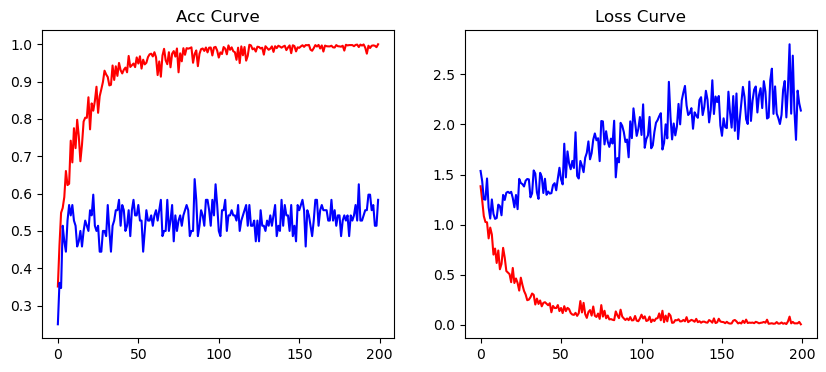

In [210]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.show()

### fine-tuning (SI+FT)

In [211]:
### TODO: build the fine-tuning dataloader ###

valid_id = '01' # chosen valid set
    
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{valid_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

for c in range(4):
    x_, y_ = x_data[y_data == c], y_data[y_data == c]
    x_train = np.append(x_train, x_[:54], axis=0)
    y_train = np.append(y_train, y_[:54], axis=0)
    x_valid = np.append(x_valid, x_[54:], axis=0)
    y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

# load pre-trained model
### TODO ###
ep_num = 50 # TODO: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", ep_num))
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# # Optional: lock pre-trained weight
# for param in model.parameters():
#     param.requires_grad = False

### TODO: fine-tuning training loop ###
for ep in range(ep_num):
    loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
    loss, acc = evalate_an_epoch(model, tra_loader, loss_fn)
    val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)
    print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))

Epoch 0: loss=0.8185, acc=0.7176, val_loss=1.1498, val_acc=0.6111
Epoch 1: loss=0.3806, acc=0.8472, val_loss=1.3739, val_acc=0.6528
Epoch 2: loss=0.1032, acc=0.9861, val_loss=0.9085, val_acc=0.6250
Epoch 3: loss=0.0525, acc=1.0000, val_loss=0.9253, val_acc=0.6389
Epoch 4: loss=0.0327, acc=1.0000, val_loss=0.9031, val_acc=0.6944
Epoch 5: loss=0.0281, acc=1.0000, val_loss=0.8742, val_acc=0.6806
Epoch 6: loss=0.0207, acc=1.0000, val_loss=1.1110, val_acc=0.6944
Epoch 7: loss=0.0143, acc=1.0000, val_loss=0.8858, val_acc=0.7083
Epoch 8: loss=0.0122, acc=1.0000, val_loss=1.0122, val_acc=0.6528
Epoch 9: loss=0.0109, acc=1.0000, val_loss=0.9667, val_acc=0.6528
Epoch 10: loss=0.0112, acc=1.0000, val_loss=0.9092, val_acc=0.6528
Epoch 11: loss=0.0088, acc=1.0000, val_loss=1.0782, val_acc=0.6944
Epoch 12: loss=0.0081, acc=1.0000, val_loss=1.1404, val_acc=0.7083
Epoch 13: loss=0.0067, acc=1.0000, val_loss=0.9558, val_acc=0.6944
Epoch 14: loss=0.0061, acc=1.0000, val_loss=1.0827, val_acc=0.6806
Epoch

## Test

In [212]:
# load pre-trained model
best_epoch = 100 # TODO: determine the `BEST` epoch
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
ev = evalate_an_epoch(model, test_loader, loss_fn)
print(ev)

test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])
(2.0165588789516025, 0.5416666666666666)


## Analyzing
You need to do some further analysis including
- confusion matrix, 
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section


Model: ShallowConvNet Scheme: sift , accuracy =  0.4375


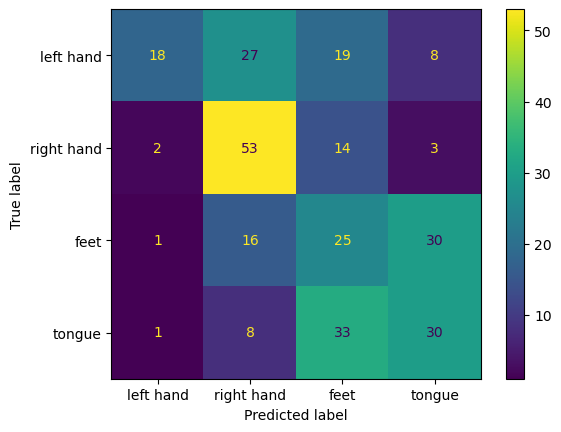

In [213]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.
from sklearn import metrics
import pandas as pd

js = pd.read_json('/kaggle/input/bci-homework-3-kaggle-judge/BCI_hw3_dataset/data_detail.json')
label_list = js.iloc[0, 2:6].values


model_name = 'ShallowConvNet'
eegmodel = ShallowConvNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(dropoutRate=0.5) # custom args for different EEG model
model = eegmodel(22, 562, 4)
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])
model.eval()

mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()

x = torch.from_numpy(mat["x_test"])
x = x.unsqueeze(1).to('cpu', dtype=torch.float)
y_pred = model(x).argmax(dim=1).detach().cpu().numpy()

pred_list = (y == y_pred)
acc = len([t for t in pred_list if t]) / len(pred_list)
print('\nModel:', model_name, 'Scheme:', scheme, ', accuracy = ', round(acc, 4))
confusion_matrix = metrics.confusion_matrix(y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=label_list)

cm_display.plot()
plt.show()

## Generate Submission csv File

In [214]:
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])

model.eval()
fd = open("simple_sd.csv", "w")
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
for sid in ["05", "06", "0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to('cpu', dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()

RuntimeError: Error(s) in loading state_dict for SCCNet:
	Missing key(s) in state_dict: "conv1.0.weight", "conv1.1.weight", "conv1.1.bias", "conv1.1.running_mean", "conv1.1.running_var", "conv2.0.weight", "conv2.1.weight", "conv2.1.bias", "conv2.1.running_mean", "conv2.1.running_var", "classifier.0.weight", "classifier.0.bias". 
	Unexpected key(s) in state_dict: "Bn1.weight", "Bn1.bias", "Bn1.running_mean", "Bn1.running_var", "Bn1.num_batches_tracked", "conv1.weight", "conv2.weight", "classifier.weight", "classifier.bias". 

In [ ]:
import pandas as pd
df = pd.read_csv('/kaggle/working/simple_sd.csv')
print(df)